# SAM

使用SAM（Sharpness Awareness Minimization）降低过拟合，它可以同时减小损失值和损失的锐度。它与其他常见的优化器一起使用，比如SGD/Adam。
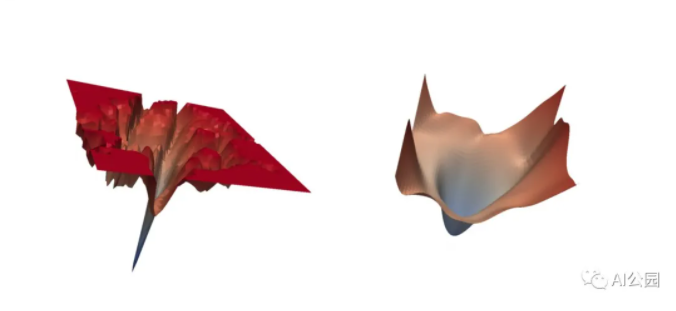
(左))用SGD训练的ResNet收敛到的一个尖锐的最小值。(右)用SAM训练的相同的ResNet收敛到的一个平坦的最小值。

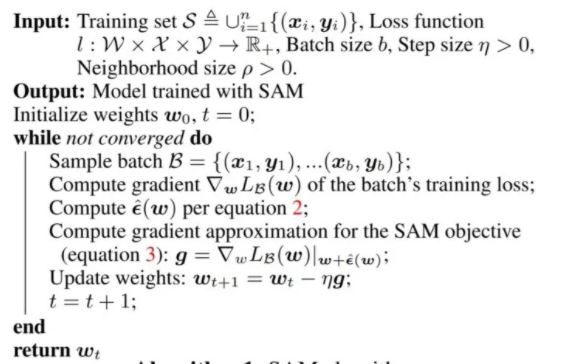

In [1]:
import torch

class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    # 我们计算epsilon(e_w)并将其添加到参数中
    @torch.no_grad()
    def first_step(self, zero_grad=False): 
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                e_w = p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"
                self.state[p]["e_w"] = e_w

        if zero_grad: self.zero_grad()

    # 我们必须回到之前的权重来计算基础优化器的实际步骤
    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.sub_(self.state[p]["e_w"])  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    # 函数_grad_norm用于返回矩阵向量的norm
    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        p.grad.norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

使用方法

In [ ]:
from sam import SAM

model = YourModel()
base_optimizer = torch.optim.SGD  # define an optimizer for the "sharpness-aware" update
optimizer = SAM(model.parameters(), base_optimizer, lr=0.1, momentum=0.9)


for input, output in data:

  # first forward-backward pass
  loss = loss_function(output, model(input))  # use this loss for any training statistics
  loss.backward()
  optimizer.first_step(zero_grad=True)
  
  # second forward-backward pass
  loss_function(output, model(input)).backward()  # make sure to do a full forward pass
  optimizer.second_step(zero_grad=True)

## 缺点：
虽然SAM的泛化效果较好，但是这种方法的主要缺点是，由于前后两次计算锐度感知梯度，需要花费两倍的训练时间。而且不一定对所有的都有效。